# HW05
## ABDULLAH AL NOMAN
### an0652@uah.edu

## Practice

### 1. Machine Learning Deployment for MNIST Dataset

#### 1.1 Convolutional Neural Network for MNIST Dataset

##### 1. Dataset normalization

In [1]:
# installing onnx, onnxruntime
!pip install --quiet onnx onnxruntime

# importing required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import onnx, onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

# data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# downloading the full MNIST training dataset and applying the transformation
full_mnist = datasets.MNIST(root=".", download=True, train=True, transform=transform)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.9 MB/s eta 0:00:00


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


##### 2. Dataset division into training and test cases

In [2]:
train_len   = int(len(full_mnist) * 2/3)
test_len    = len(full_mnist) - train_len # 1/3 for testing
train_set, test_set = random_split(full_mnist, [train_len, test_len]) # splitting

# batch size setting for training and testing
batch_size = 128

# creating dataloader for training set
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

# creating dataloader for testing set
test_loader  = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

##### 3. CNN model implementation

In [3]:
# defining CNN for MNIST classification
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # feature extractions
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # classifier for fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1600, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )

    # defining how input flows through the model using forward pass
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MNIST_CNN().to(device) # initialize the model

##### 4. Choosing learning rate, optimizer

In [4]:
# training configuration
epochs       = 10
lr           = 1e-3
criterion    = nn.CrossEntropyLoss() # loss function
optimizer    = optim.Adam(model.parameters(), lr=lr) # optimizer

##### 5. BONUS: Learning rate scheduler implementation

In [5]:
# lr scheduler decays the learning rate by gamma every 3 epochs
scheduler = StepLR(optimizer, step_size=3, gamma=0.3)

# function to run a single epoch
def run_epoch(loader, train=True):
    model.train(mode=train)
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x)
        loss   = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        # accumulating loss and accuracy
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    # returning avg loss and accuracy
    return total_loss / total, correct / total

# loops for multiple epoches
for epoch in range(1, epochs+1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    test_loss,  test_acc  = run_epoch(test_loader,  train=False)
    scheduler.step()

    # displaying results
    print(f"Epoch {epoch:02d} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.3f} | "
          f"Test Loss {test_loss:.4f}  Acc {test_acc:.3f}")

Epoch 01 | Train Loss 0.4514 Acc 0.860 | Test Loss 0.1103  Acc 0.967
Epoch 02 | Train Loss 0.1359 Acc 0.960 | Test Loss 0.0773  Acc 0.976
Epoch 03 | Train Loss 0.0990 Acc 0.971 | Test Loss 0.0609  Acc 0.981
Epoch 04 | Train Loss 0.0734 Acc 0.979 | Test Loss 0.0520  Acc 0.984
Epoch 05 | Train Loss 0.0650 Acc 0.981 | Test Loss 0.0497  Acc 0.985
Epoch 06 | Train Loss 0.0597 Acc 0.983 | Test Loss 0.0467  Acc 0.986
Epoch 07 | Train Loss 0.0526 Acc 0.984 | Test Loss 0.0466  Acc 0.986
Epoch 08 | Train Loss 0.0502 Acc 0.985 | Test Loss 0.0459  Acc 0.986
Epoch 09 | Train Loss 0.0499 Acc 0.985 | Test Loss 0.0453  Acc 0.987
Epoch 10 | Train Loss 0.0462 Acc 0.987 | Test Loss 0.0455  Acc 0.986


##### 6. Saving the model as ONNX format

In [6]:
dummy = torch.randn(1, 1, 28, 28, device=device)
onnx_path = "mnist_cnn.onnx" # setting putput path

# exporting the trained model to ONNX format
torch.onnx.export(
    model,
    dummy,
    onnx_path,
    input_names=['input'],
    output_names=['logits'],
    dynamic_axes={
        'input': {0: 'batch'},
        'logits': {0: 'batch'}
    },
    opset_version=13
)

# displaying export message
print(f"ONNX model saved to {onnx_path}")

ONNX model saved to mnist_cnn.onnx


##### 7. Loading the ONNX model and testing

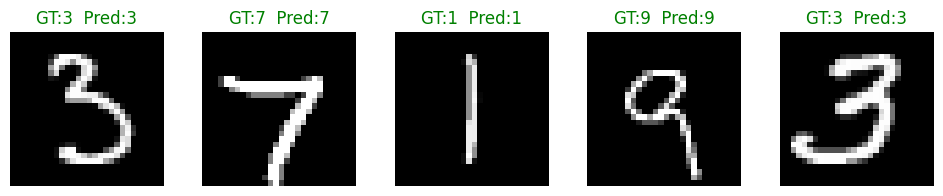

In [7]:
# loading the exported ONNX model using ONNX Runtime
ort_sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])

# picking 5 random samples from the test_set
idx = torch.randint(0, len(test_set), (5,))
images, labels = zip(*[test_set[i] for i in idx])
images = torch.stack(images)        # (5,1,28,28)
labels = torch.tensor(labels)

# run inference on the selected images
logits = ort_sess.run(None, {'input': images.numpy()})[0]
preds  = torch.tensor(logits).argmax(dim=1)

# visual checking
fig, axs = plt.subplots(1, 5, figsize=(12,2))
for i,(img, gt, pd) in enumerate(zip(images, labels, preds)):
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(f"GT:{gt}  Pred:{pd}", color=("green" if gt==pd else "red"))
    axs[i].axis('off')
plt.show() # display

#### 1.2 Developing Flask based Web Applications

$Please$ $refer$ $to$ $my$ $GitHub$ $repository$ $below.$
- https://github.com/NomanAbdullah/Abdullah-Flask-Web-Application